Running with ABC...


Running with ABC:   0%|          | 0/6944 [00:00<?, ?it/s]

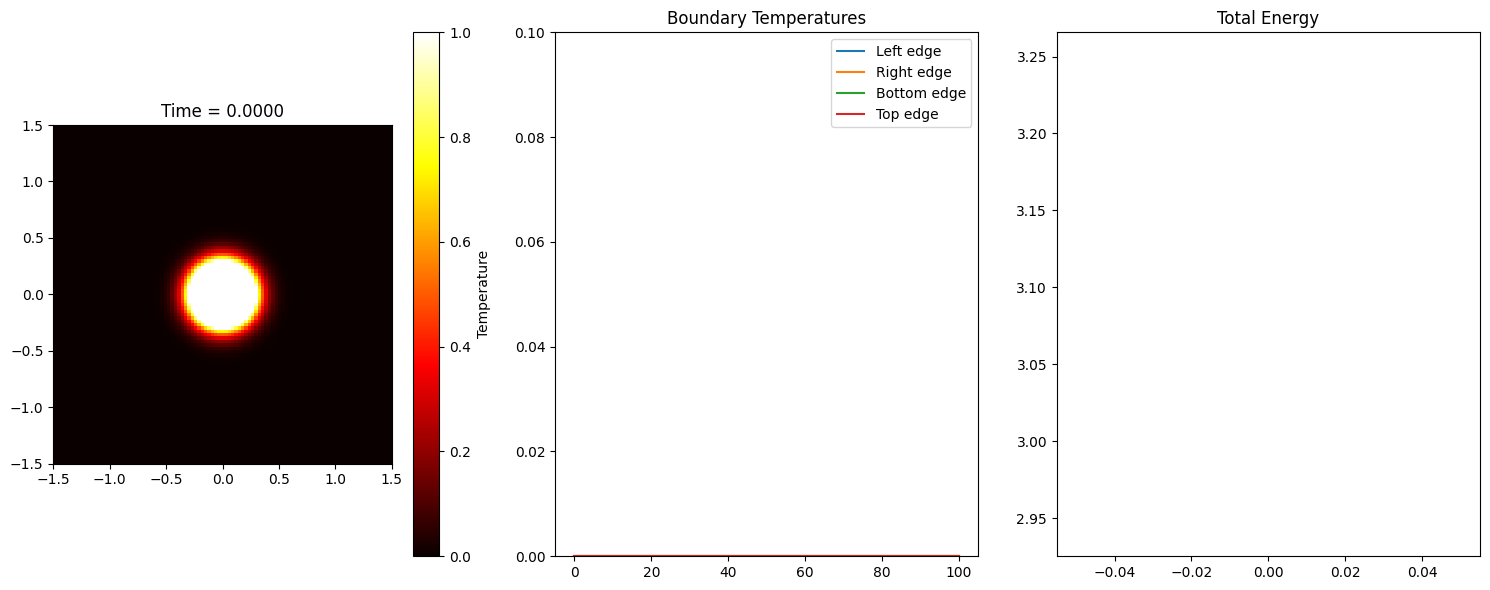

Running with ABC:   7%|▋         | 499/6944 [00:30<05:58, 18.00it/s]

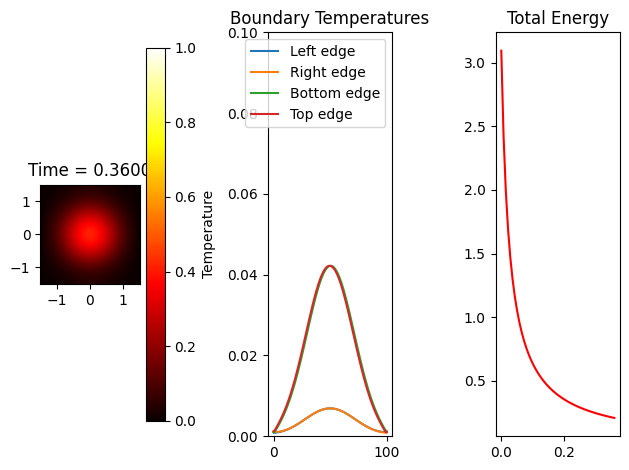

Running with ABC:  14%|█▍        | 999/6944 [01:01<05:53, 16.81it/s]

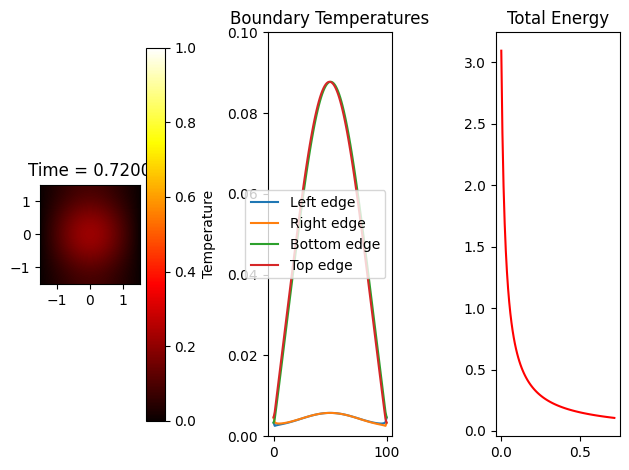

Running with ABC:  22%|██▏       | 1499/6944 [01:32<05:33, 16.34it/s]

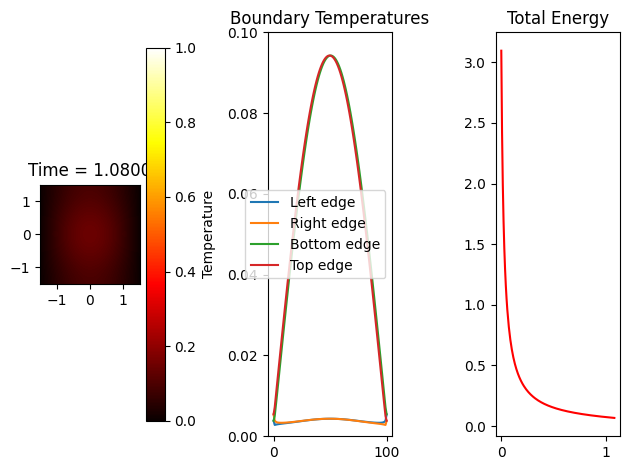

Running with ABC:  29%|██▉       | 1999/6944 [02:02<04:46, 17.27it/s]

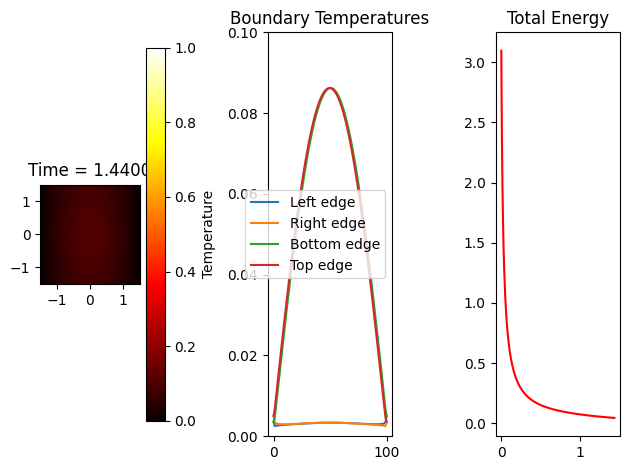

Running with ABC:  36%|███▌      | 2499/6944 [02:32<04:12, 17.63it/s]

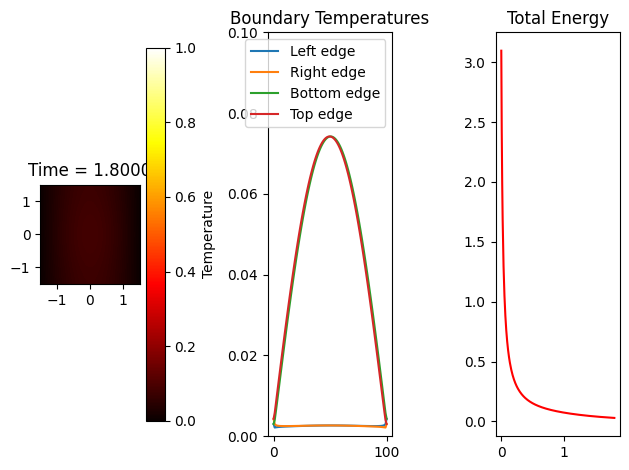

Running with ABC:  43%|████▎     | 2999/6944 [03:02<03:47, 17.36it/s]

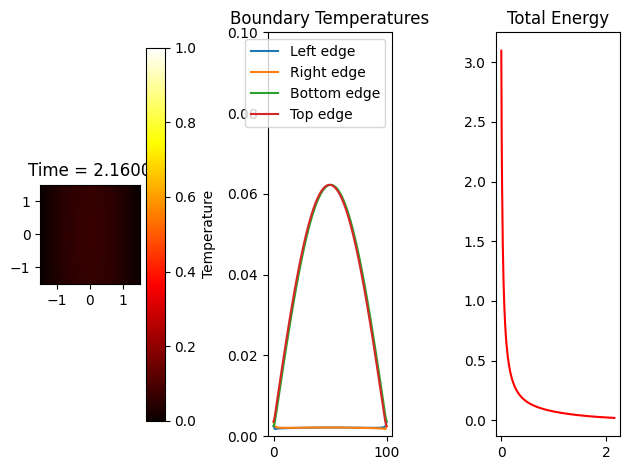

Running with ABC:  50%|█████     | 3499/6944 [03:31<03:08, 18.32it/s]

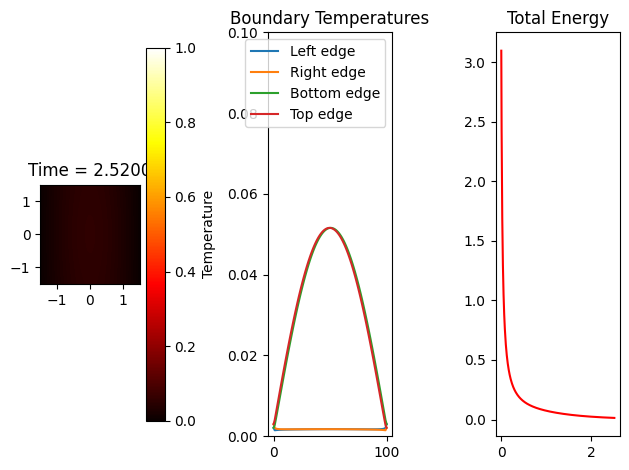

Running with ABC:  58%|█████▊    | 3999/6944 [04:01<02:49, 17.42it/s]

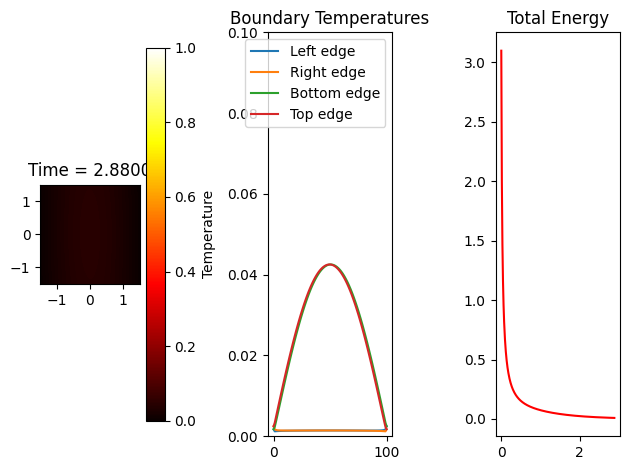

Running with ABC:  65%|██████▍   | 4499/6944 [04:32<02:26, 16.74it/s]

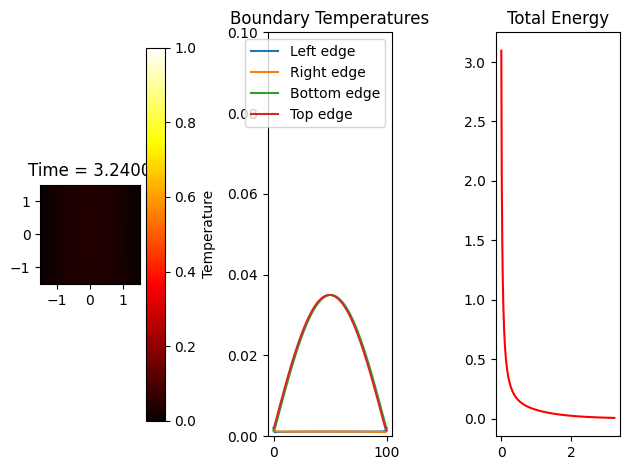

Running with ABC:  72%|███████▏  | 4999/6944 [05:02<01:55, 16.90it/s]

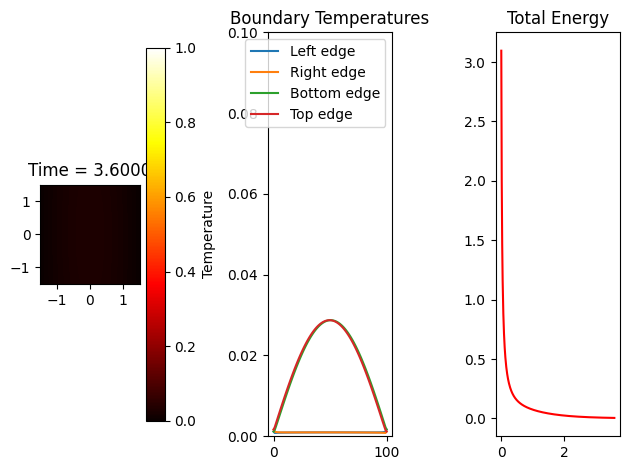

Running with ABC:  79%|███████▉  | 5499/6944 [05:33<01:28, 16.39it/s]

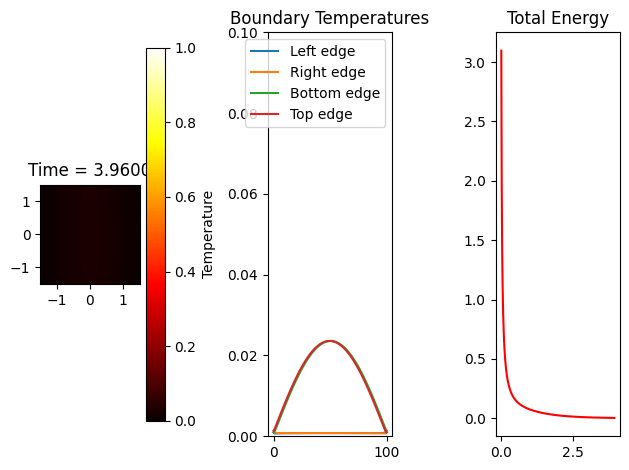

Running with ABC:  86%|████████▋ | 5999/6944 [06:02<00:53, 17.80it/s]

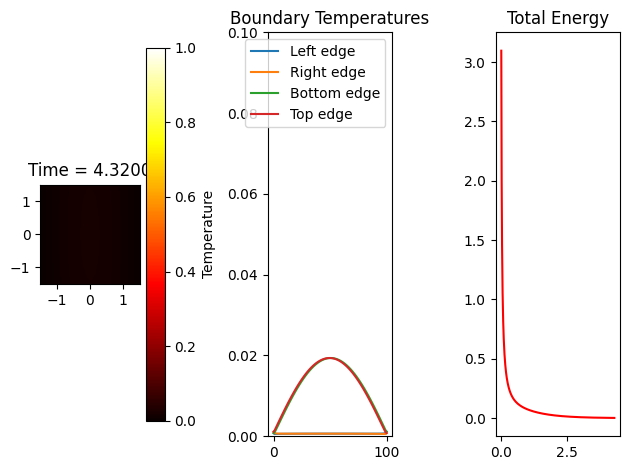

Running with ABC:  94%|█████████▎| 6499/6944 [06:31<00:24, 18.05it/s]

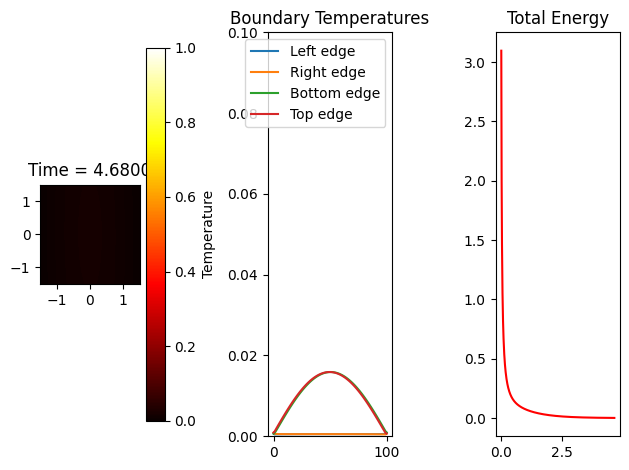

Running with ABC: 100%|█████████▉| 6943/6944 [06:57<00:00, 17.41it/s]

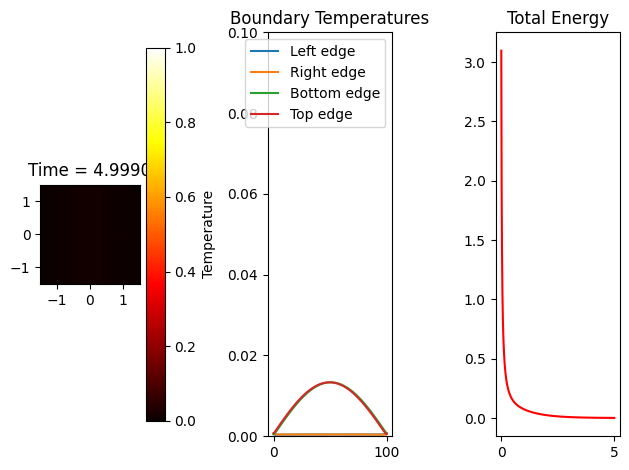

Running with ABC: 100%|██████████| 6944/6944 [06:58<00:00, 16.60it/s]



Running without ABC...


Running without ABC:   0%|          | 0/624 [00:00<?, ?it/s]

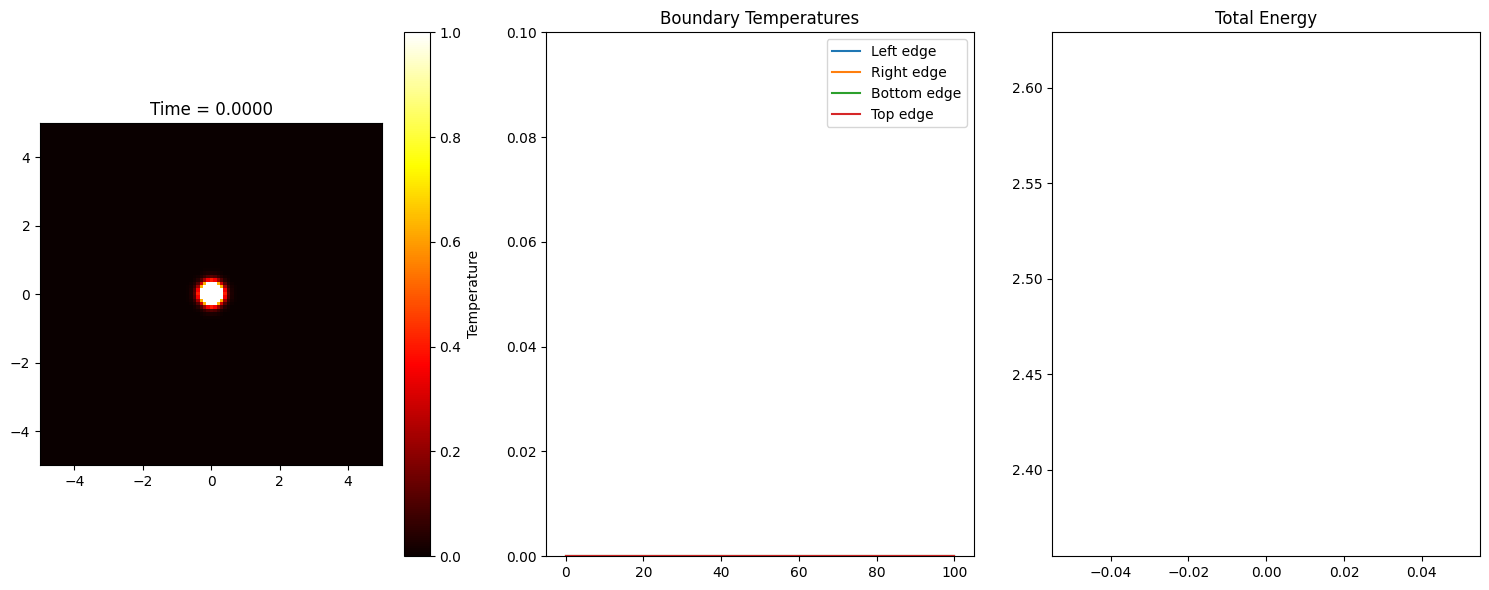

Running without ABC:  80%|███████▉  | 499/624 [00:28<00:07, 16.15it/s]

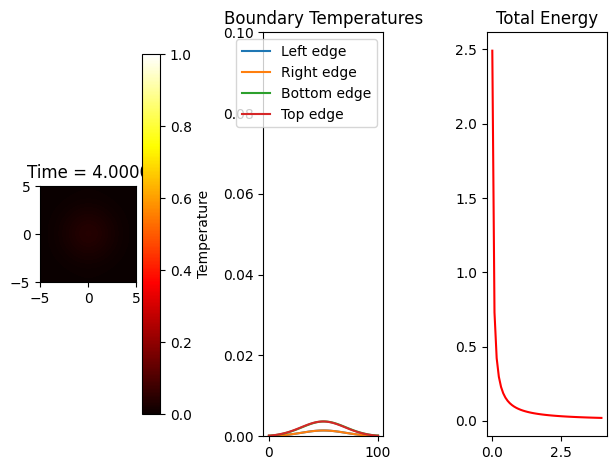

Running without ABC: 100%|█████████▉| 623/624 [00:36<00:00, 18.10it/s]

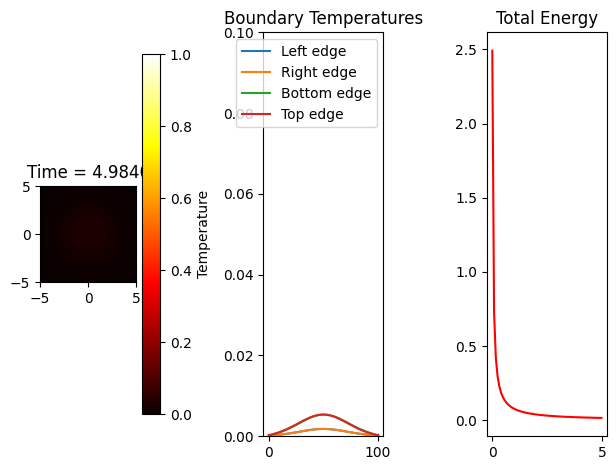

Running without ABC: 100%|██████████| 624/624 [00:37<00:00, 16.69it/s]


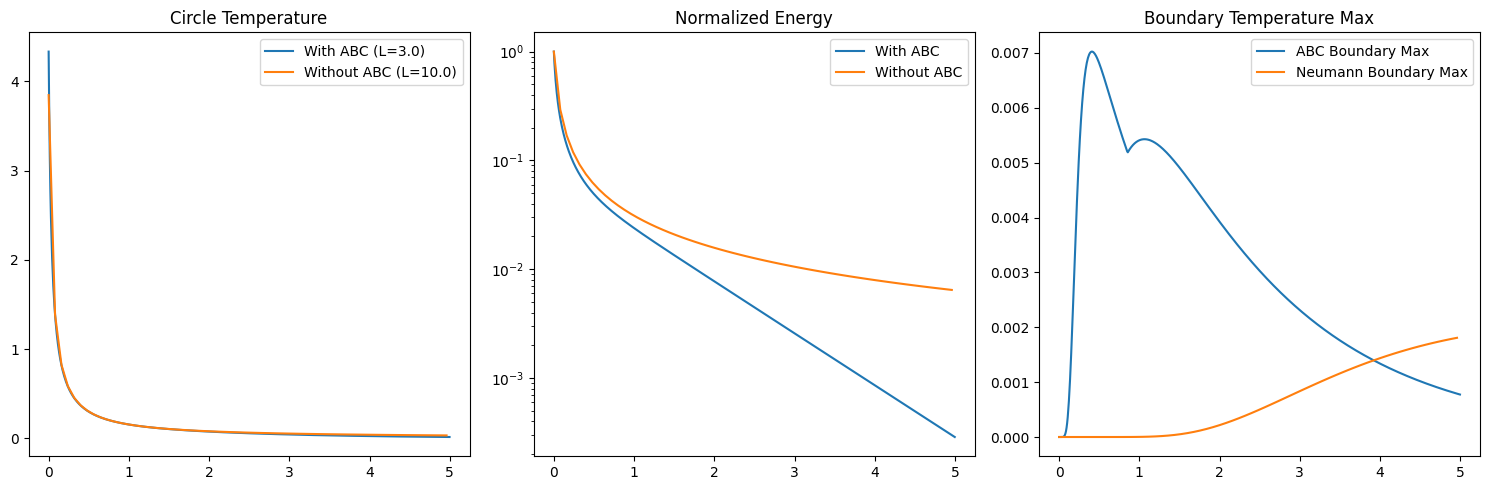

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from tqdm import tqdm
import matplotlib.colors as colors

# ======================
# Parameters
# ======================
a = 0.5               # Thermal diffusivity
L = 3.0               # Domain size
L_large = 10.0        # Larger domain for comparison
Nx, Ny = 101, 101     # Grid resolution
T = 5              # Simulation time

# ABC parameters
N_pade = 3            # Padé approximation order
z0 = 1.0              # Expansion point

# Calculate Padé coefficients
a_k = np.array([np.cos((k * np.pi) / (2 * N_pade + 1))**2 for k in range(1, N_pade+1)])
b_k = np.array([(2 / (2 * N_pade + 1)) * np.sin((k * np.pi) / (2 * N_pade + 1))**2 
                for k in range(1, N_pade+1)])

# ======================
# ABC Manager Class
# ======================
class ABCManager:
    def __init__(self, N, dt, a, z0, a_k, b_k):
        self.N = N
        self.dt = dt
        self.a = a
        self.z0 = z0
        self.z0_corner = 2.0 * z0  # Stronger absorption for corners
        self.a_k = a_k
        self.b_k = b_k
        self.w_x = [np.zeros(Ny-2) for _ in range(N)]  # For x-direction
        self.w_y = [np.zeros(Nx-2) for _ in range(N)]  # For y-direction
        self.w_corner = [0.0 for _ in range(N)]       # For corners
        
    def update_edge(self, u_boundary, u_prev_boundary, u_interior, dx, direction='x'):
        """Stable edge update with energy monitoring"""
        w = self.w_x if direction == 'x' else self.w_y
        new_w = []
        for k in range(self.N):
            new_w_k = (w[k] - (self.dt * self.z0 * (1 - self.a_k[k])) * w[k] + 
                      (self.dt / self.a_k[k]) * (self.z0 * u_boundary - 
                      (u_boundary - u_prev_boundary)/(self.a**2 * self.dt)))
            new_w.append(new_w_k)
        
        sum_bw = sum(self.b_k[k] * new_w[k] for k in range(self.N))
        bc_value = u_interior - dx * (np.sqrt(self.z0) * u_boundary + dx * np.sqrt(self.z0) * sum_bw)
        
        if direction == 'x': 
            self.w_x = new_w
        else: 
            self.w_y = new_w
        return bc_value
    
    def update_corner(self, u_corner, u_prev_corner, u_xinterior, u_yinterior, dx, dy):
        """Over-damped corner treatment"""
        new_w = []
        for k in range(self.N):
            new_w_k = (self.z0_corner * u_corner - 
                      (u_corner - u_prev_corner)/(self.a**2 * self.dt)) / \
                     (self.z0_corner * (1 - self.a_k[k]) + self.a_k[k]/(self.a**2 * self.dt))
            new_w.append(new_w_k)
        
        return 0.5*(u_xinterior + u_yinterior) - 0.25*(dx+dy)*np.sqrt(self.z0_corner)*u_corner

# ======================
# Simulation Functions
# ======================
def setup_implicit_matrix(Nx, Ny, alpha):
    """Create sparse matrix with ABC-friendly boundary setup"""
    main_diag = np.ones(Nx*Ny) * (1 + 4*alpha)
    x_diag = np.ones(Nx*Ny - 1) * (-alpha)
    y_diag = np.ones(Nx*Ny - Nx) * (-alpha)
    
    A = diags([main_diag, x_diag, x_diag, y_diag, y_diag], 
              [0, 1, -1, Nx, -Nx], format='csr')
    return A

def run_simulation(L_value, use_abc=True):
    """Run simulation with diagnostics"""
    # Grid setup
    dx = dy = L_value / (Nx - 1)
    x = np.linspace(-L_value/2, L_value/2, Nx)
    y = np.linspace(-L_value/2, L_value/2, Ny)
    X, Y = np.meshgrid(x, y, indexing='ij')
    r = np.sqrt(X**2 + Y**2)
    circle_mask = r <= 0.2
    
    # Dynamic time stepping
    dt = 0.4 * (dx**2) / a  # Conservative CFL
    nt = int(T / dt)
    
    # Initial condition
    def gaussian(x, y, t0=0.05):
        return np.exp(-(x**2 + y**2)/(4*a**2*(t0 + 1e-6))) / (4*a**2*np.pi*(t0 + 1e-6))
    u = gaussian(X, Y)
    u_prev = u.copy()
    
    # ABC setup
    if use_abc:
        abc = {
            'left': ABCManager(N_pade, dt, a, z0, a_k, b_k),
            'right': ABCManager(N_pade, dt, a, z0, a_k, b_k),
            'top': ABCManager(N_pade, dt, a, z0, a_k, b_k),
            'bottom': ABCManager(N_pade, dt, a, z0, a_k, b_k)
        }
    
    # Matrix setup
    alpha = dt * a / dx**2
    A = setup_implicit_matrix(Nx, Ny, alpha)
    
    # Diagnostics
    results = {
        'time': [],
        'temp': [],
        'energy': [],
        'boundary_left': [],
        'boundary_right': []
    }
    
    plt.figure(figsize=(15, 6))
    
    for n in tqdm(range(nt), desc=f"Running {'with ABC' if use_abc else 'without ABC'}"):
        u_prev = u.copy()
        
        # Implicit solve
        u = spsolve(A, u_prev.ravel()).reshape(Nx, Ny)
        
        # Boundary treatment
        if use_abc:
            # Edges
            u[0,1:-1] = abc['left'].update_edge(u[0,1:-1], u_prev[0,1:-1], u[1,1:-1], dx, 'x')
            u[-1,1:-1] = abc['right'].update_edge(u[-1,1:-1], u_prev[-1,1:-1], u[-2,1:-1], dx, 'x')
            u[1:-1,0] = abc['bottom'].update_edge(u[1:-1,0], u_prev[1:-1,0], u[1:-1,1], dy, 'y')
            u[1:-1,-1] = abc['top'].update_edge(u[1:-1,-1], u_prev[1:-1,-1], u[1:-1,-2], dy, 'y')
            
            # Corners (using right/bottom ABC as base)
            u[0,0] = abc['bottom'].update_corner(u[0,0], u_prev[0,0], u[1,0], u[0,1], dx, dy)
            u[0,-1] = abc['top'].update_corner(u[0,-1], u_prev[0,-1], u[1,-1], u[0,-2], dx, dy)
            u[-1,0] = abc['right'].update_corner(u[-1,0], u_prev[-1,0], u[-2,0], u[-1,1], dx, dy)
            u[-1,-1] = abc['right'].update_corner(u[-1,-1], u_prev[-1,-1], u[-2,-1], u[-1,-2], dx, dy)
        else:
            # Pure Neumann
            u[0,:] = u[1,:]; u[-1,:] = u[-2,:]
            u[:,0] = u[:,1]; u[:,-1] = u[:,-2]
        
        # Store diagnostics
        if n % 10 == 0:
            results['time'].append(n * dt)
            results['temp'].append(np.mean(u[circle_mask]))
            results['energy'].append(np.sum(u**2) * dx * dy)
            results['boundary_left'].append(np.max(np.abs(u[0,:])))
            results['boundary_right'].append(np.max(np.abs(u[-1,:])))
        
        # Visualization
        if n % 500 == 0 or n == nt-1:
            plt.clf()
            
            # Field plot
            plt.subplot(1, 3, 1)
            norm = colors.LogNorm(vmin=1e-4, vmax=1)
            plt.imshow(u.T, origin='lower', extent=[-L_value/2, L_value/2, -L_value/2, L_value/2], cmap='hot', vmin=0, vmax=1)
            plt.colorbar(label='Temperature')
            plt.title(f'Time = {n*dt:.4f}')
            
            # Boundary plot
            plt.subplot(1, 3, 2)
            plt.plot(u[0,:], label='Left edge')
            plt.plot(u[-1,:], label='Right edge')
            plt.plot(u[:,0], label='Bottom edge')
            plt.plot(u[:,-1], label='Top edge')
            plt.ylim(0, 0.1)
            plt.legend()
            plt.title('Boundary Temperatures')
            
            # Energy plot
            plt.subplot(1, 3, 3)
            plt.plot(results['time'], results['energy'], 'r-')
            plt.title('Total Energy')
            plt.tight_layout()
            plt.pause(0.01)
        
        # Stability check
        if np.max(u) > 1e3:
            print(f"Instability detected at step {n}")
            break
    
    # Convert lists to arrays
    for key in results:
        results[key] = np.array(results[key])
    
    return results

# ======================
# Run and Compare
# ======================
print("Running with ABC...")
results_abc = run_simulation(L, use_abc=True)

print("\nRunning without ABC...")
results_noabc = run_simulation(L_large, use_abc=False)

# Final comparison
plt.figure(figsize=(15, 5))

# Temperature comparison
plt.subplot(1, 3, 1)
plt.plot(results_abc['time'], results_abc['temp'], label=f'With ABC (L={L})')
plt.plot(results_noabc['time'], results_noabc['temp'], label=f'Without ABC (L={L_large})')
#plt.ylim(0, 0.2)
plt.legend()
plt.title('Circle Temperature')

# Energy comparison
plt.subplot(1, 3, 2)
plt.plot(results_abc['time'], results_abc['energy']/results_abc['energy'][0], label='With ABC')
plt.plot(results_noabc['time'], results_noabc['energy']/results_noabc['energy'][0], label='Without ABC')
plt.yscale('log')
plt.legend()
plt.title('Normalized Energy')

# Boundary comparison
plt.subplot(1, 3, 3)
plt.plot(results_abc['time'], results_abc['boundary_left'], label='ABC Boundary Max')
plt.plot(results_noabc['time'], results_noabc['boundary_left'], label='Neumann Boundary Max')
plt.legend()
plt.title('Boundary Temperature Max')

plt.tight_layout()
plt.show()